# About

- `Main Author:` E. Miles Stoudenmire
- `Source:` [ArXiv](https://arxiv.org/abs/1801.00315)
- `Publish Date:` 31-12-2017
- `Reviewed Date:` 07-06-2021

## Citation

```latex
@article{stoudenmire2018learning,
  title={Learning relevant features of data with multi-scale tensor networks},
  author={Stoudenmire, E Miles},
  journal={Quantum Science and Technology},
  volume={3},
  number={3},
  pages={034003},
  year={2018},
  publisher={IOP Publishing}
}
```

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Utilities

In [3]:
from typing import Tuple

def is_power_of_two(n: int) -> bool:
    """
    Check if a given number is a power of two.
    """
    return (n & (n-1) == 0) and n != 0


def power_of_two(n: int) -> Tuple[int, int]:
    """
    Given a number, returns it's previous 
    and next of keen which are powers of two.
    """
    if is_power_of_two(n):
        return n, n
    count = 0    
    while n != 0:
        n >>= 1
        count += 1
    prec = 1 << (count-1)
    succ = 1 << count
    return prec, succ

# Loading MNIST dataset

In [4]:
from typing import Optional

def load_mnist(data_path: str) -> np.ndarray:
    num_labels = 10
    img_size = 28

    # data files
    train_data_path = os.path.join(data_path, 'mnist_train.csv')
    test_data_path = os.path.join(data_path, 'mnist_test.csv')

    # loading data
    train_data = np.loadtxt(train_data_path, delimiter=',')
    test_data = np.loadtxt(test_data_path, delimiter=',')

    # TLDR; scaling to [0.01, 0.99]; we want to avoid zeros and ones
    # Longer answer: https://arxiv.org/pdf/1512.00567.pdf
    frac = 0.99 / 255

    # extracting data and labels
    train_images = np.asfarray(train_data[:, 1:]) * frac + 0.01
    train_labels = np.asfarray(train_data[:, :1])

    test_images = np.asfarray(test_data[:, 1:]) * frac + 0.01
    test_labels = np.asfarray(test_data[:, :1])

    # transform labels into one hot representation
    lr = np.arange(num_labels)
    train_labels_one_hot = (lr==train_labels).astype(float)
    test_labels_one_hot = (lr==test_labels).astype(float)

    # we don't want zeroes and ones in the labels either
    train_labels_one_hot[train_labels_one_hot==0] = 0.01
    train_labels_one_hot[train_labels_one_hot==1] = 0.99
    test_labels_one_hot[test_labels_one_hot==0] = 0.01
    test_labels_one_hot[test_labels_one_hot==1] = 0.99

    return {
        'train': {
            'images': train_images,
            'labels': train_labels_one_hot
        },
        'test': {
            'images': test_images,
            'labels': test_labels_one_hot
        }
    }

In [5]:
data = load_mnist('../data/mnist')

Quickly checking that data is loaded correctly

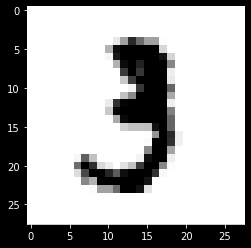

In [6]:
j = 10   # a particularr image index
img_vec = data['train']['images'][j]
size = np.sqrt(img_vec.size).astype(int)
img = img_vec.reshape(size, size)

plt.imshow(img, cmap="Greys")
plt.show()


# Process images

We need to rescale image so the size of eacch image is a power of $2$. This is required for the algorithm to work. First, we determine the nearest powers of $2$ given the size of each image.

In [7]:
j = 10   # a particularr image index
img_vec = data['train']['images'][j]
size_ = np.sqrt(img_vec.size).astype(int)
size, _ = power_of_two(size_)   # returns nearest powers of 2

print(f'The suggested new size is: {size}.')

The suggested new size is: 16.


Now, we downscale each image to this new size.


In [8]:
import cv2

def resize(image_vec: np.ndarray, shape: Tuple[int,int]) -> np.ndarray:
    orig_size = np.sqrt(img_vec.size).astype(int)
    image = image_vec.reshape(orig_size, orig_size)
    image = cv2.resize(image, shape, interpolation=cv2.INTER_CUBIC)
    return image.reshape(-1,1)
    
new_shape = (8,8)

train_images = np.squeeze(np.apply_along_axis(lambda x: resize(x, new_shape), axis=1, arr=data['train']['images']))
test_images = np.squeeze(np.apply_along_axis(lambda x: resize(x, new_shape), axis=1, arr=data['test']['images']))

In [9]:
train_images.shape

(60000, 64)

Checking if data is scaled properly by plotting random digits...

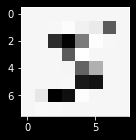

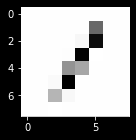

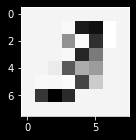

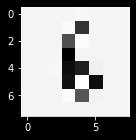

In [10]:
def show_digit(image_vec):
    size = np.sqrt(image_vec.size).astype(int)
    plt.rcParams["figure.figsize"] = (2,2)
    plt.imshow(image_vec.reshape(size, size), cmap="Greys")
    plt.show()

digits_idx = (0,23,157,996)    # plot random images
for j in digits_idx:
    show_digit(train_images[j])

# Feature map

The feature map $\Phi(\bf x)$ maps inpunt data vector $\bf x$ from a space of dimension $N$ to a space of dimension $d^N$, i.e. each component of the input vector $x_j$ is mapped into a $d$-dimensional vector. See Eq. 8 in text.

The tensor $\Phi^{s_1 s_2 \cdots s_N}$ is the tensor productof the local feature maps $\Phi^{s_j}(x_j)$ applied to each input $x_j$ along the indices $s_j = 1,2,\cdots,N$. The local feature map is required to have unit norm analogous to the wave function norm, otherwise the tensor networks are not guaranteed to be numerically stable.



In [11]:
from typing import Callable, Iterable, Optional

FMap = Callable[np.ndarray, np.ndarray] # type alias

def feature_map(xs: Iterable, 
                f: FMap,
                *fs: Iterable[FMap],
                acc: Optional[np.ndarray]=None) -> np.ndarray:
    """
    Feature mapping for a single data sample (image vector).
    Input:
    ------

    Output:
    -------
    An array containing feature values for each vector value.
    The size of the output is features x vector
    """
    vf = np.vectorize(f)
    acc = vf(xs) if acc is None else np.r_[acc, vf(xs)]
    if fs:
        yield from feature_map(xs, *fs, acc=acc)
    else:
        yield acc

def tensorize_dataset(a: np.ndarray, *fs: Iterable[FMap]) -> np.ndarray:
    """
    The tensorization of the dataset.
    Input:
    ------
    a:      Dataset containing images with pixels aranged as a long vector.
    fs:     Features

    Output:
    -------
    """
    n,m = a.shape
    # feature extractor iterator
    feat_extractor_iterator = feature_map(a,*fs)
    # creating features
    phi = np.vstack(*feat_extractor_iterator)
    # rearranging features for convenience
    return phi.reshape(len(fs),n,m).transpose(0,2,1)

features = [
    lambda _: 1,
    lambda x: x,
]
# features = [
#   lambda x: np.cos( (np.pi/2) * x ),
#   lambda x: np.sin( (np.pi/2) * x ),
# ]
phi_train = tensorize_dataset(train_images, *features)
phi_test = tensorize_dataset(test_images, *features)

In [12]:
phi_train.shape

(2, 64, 60000)

Normalizing the features so we can trivially contract them

In [13]:
# def normalize_along_axis(a: np.ndarray, 
#                          ord: Optional[int] = 2,
#                          axis: Optional[int] = -1) -> np.ndarray:
#     z = np.atleast_1d(np.linalg.norm(a, ord, axis))
#     z[z==0] = 1
#     return a / np.expand_dims(z, axis)
#
#Phi = normalize_along_axis(phi_train, axis=0)

checking the normalization on a random sample of features and images

In [14]:
# sample_size = 10
#
# for i in range(sample_size):
#     m = np.random.choice(phi_train.shape[1])
#     n = np.random.choice(phi_train.shape[2])
#     assert np.allclose(phi_train[:,m,n].T @ phi_train[:,m,n], 1)

Checking if images are correctly processed...

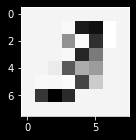

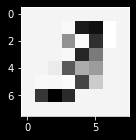

In [15]:
j = 157                       # specific image id
img = phi_train[:,:,j]        # each image is a (1,x) represenattion
show_digit(train_images[j])   # original image
show_digit(img[1,:])          # image asfter the feature map


# Computing the reduced covariance matrix and truncate

In [16]:
from typing import Iterable

def sliding_window(xs: Iterable,
                   size: int, 
                   step: Optional[int] = 1,
                   complement: Optional[bool] = False) -> Iterable:
    """
    Sliding window iterator

    Input:
    ------
    xs:             Iterable.
    size:           Window size.
    step:           Step size.
    complement:     Whether to return a complement.
    
    Output:
    -------
    Iterable
    """
    assert step > 0, "Parameter 'step' must be > 0"
    N = len(xs)
    i = 0
    while i + size <= N:
        mask = np.ones(N, dtype=bool)
        mask[i:i+size] = False
        if complement:
             yield xs[~mask], xs[mask]
        else:
            yield xs[~mask]
        i += step

quickly checking

In [17]:
window_iterator = sliding_window(np.arange(10), size=2, step=2)
print(*window_iterator)

[0 1] [2 3] [4 5] [6 7] [8 9]


In [18]:
from typing import Tuple

def ishermitian(a: np.ndarray, rtol=1e-06, atol=1e-08) -> bool:
    return np.allclose(a, a.conj().T, rtol=rtol, atol=atol)

def truncate_covariance(
    a: np.ndarray,
    eps: Optional[float]=1e-3
    ) -> Tuple[np.ndarray, np.ndarray]:

    """
    Approximate the input covariance matrix by a truncated version.
    Uses the eigendecomposition to diagonaize the input matrix
    and truncates the spectrum p that satisfies the condition
    sum(p)/trace(a) < eps.

    Input:
    ------
    a:      Matrix to be truncated.
    eps:    The truncation error.

    Output:
    -------
    p:      The remaining spectrum.
    U:      The eigenvectors corresponding to p.
    D:      The index of the smallest non-negligible eigenalue.
    """
    assert ishermitian(a), 'Input matrix is not Hermitian.'    
    # the eignevalue decomposition
    p, U = np.linalg.eigh(a)  # p are sorted in ascending order
    # checking the contribution of eignevalues and get the index D
    err = np.cumsum(p / np.trace(a))  # errors see Eq. (19) in text
    idx = np.amin(np.where(err >= np.complex64(eps))[0])  # non-negligible errros
    return p, U, idx

quickly checking

In [19]:
np.random.seed(111)
v = np.random.rand(30,10) + 1j*np.random.rand(30,10)
a = v @ v.conj().T  # covariance matrix

p,U,D = truncate_covariance(a)
assert np.allclose((U[:,D:] * p[D:]) @ U[:,D:].conj().T, a)

In [20]:
from typing import Optional

def go(a: np.ndarray, eps: Optional[float]=1e-3) -> np.ndarray:
    """
    A single step building a tree layer.

    Input:
    ------
    a:      Array of input data used to construct the isometries.
    eps:    Truncation tolerance.

    Output:
    -------
    A tensor representing the isometries.
    """
    # getting the shape of the input tensor
    u,v,w = a.shape
    # precomputes all density matrices
    rho = np.einsum('ilj,klj->iklj', a, a.conj())
    # initialize the isometries
    isometries  = np.empty(shape=(u**2, u**2, 0), dtype=np.double)
    # initialize the trancation idices for each isometry
    indices = np.empty(shape=(v//2, 0), dtype=int)

    # gets the sliding window iterator
    iterator = sliding_window(np.arange(v), step=2, size=2)
    
    for i,j in iterator:

        if i == 0:
            # an edge case
            left = np.ones(w)
        else:
            # contraction of all parts to the left of the pointer (i.e. l)
            left = np.einsum('ikj,ikj->j', a[:,:i,:], a[:,:i,:].conj())

        if j == v-1:
            # an edge case
            right = np.ones(w)
        else:
            # contraction all parts to the right of the pointer (i.e. r+1)
            right = np.einsum('ikj,ikj->j', a[:,j+1:,:], a[:,j+1:,:].conj())

        # reduced density matrix for the window
        rho_ij = np.einsum('ikj,mnj->imknj', rho[:,:,i,:], rho[:,:,j,:])
        # scaled by left and right parts (aka reduced density matrix)
        rho_ij = np.einsum('...j,...j,...j', left, rho_ij, right)
        
        # eigen decomposition
        _, U, idx = truncate_covariance(rho_ij.reshape(u**2, u**2), eps)

        isometries = np.append(isometries, U[:,:,np.newaxis], axis=2)
        indices = np.append(indices, idx)

    # get a uniform trancation index for ALL isometries (see Eq. 19)
    D = np.min(indices)
    # trancating
    isometries = isometries[:,D:,:].reshape(u, u, -1, v//2)                   
    return isometries

In [21]:
def project(a, iso: np.ndarray, *other: Iterable[np.ndarray]) -> np.ndarray:
    """
    A projector of input 'a' onto the isometries.
           out      
            | 
           iso  
           / \ 
    a -> a1   a2

    Input:
    ------
    a:      Tesnor to be projected.
    iso:    Tensor with isometries to be projected on.
    other:  A tail of the iterable containing isometries. 

    Output:
    -------
    A result of the projection.
    """
    # split the array in two parts (correspond to two legs of the input)
    a1, a2 = np.split(a, 2, axis=1)
    # projection of a onto isometries
    out = np.einsum('ilk,jlk,ijml->mlk', a1, a2, iso)
    if other:
        return project(out, *other)
    else:
        return out

In [22]:
from typing import Optional, Iterator

def build_tree(a: np.ndarray, eps: Optional[float]=1e-3) -> Iterator[np.ndarray]:
    """
    A tree constructor.

    Input:
    ------
    a:      Array with input data to the tree constructor.
    eps:    Trancation tolerance.

    Output:
    -------
    An iterator spitting the isometries for each tree layer.
    """
    # getting the shape of the input tensor
    u,v,w = a.shape

    assert is_power_of_two(v), 'The number of features must be a power of 2'

    # stopping criterium
    if v > 2:
        isometries = go(a, eps=eps)
        yield isometries
        # creating the input for the next step
        a_new = project(a, isometries)
        yield from build_tree(a_new, eps=eps)

In [23]:
from typing import Optional, List

def build_tree_(a: np.ndarray, eps: Optional[float]=1e-3) -> List[np.ndarray]:
    """
    A tree constructor.

    Input:
    ------
    a:      Array with input data to the tree constructor.
    eps:    Trancation tolerance.

    Output:
    -------
    """
    # getting the shape of the input tensor
    u,v,w = a.shape                     

    assert is_power_of_two(v), 'The number of features must be a power of 2'

    layers = []
    while v > 2:
        isometries = go(a, eps=eps)
        layers.append(isometries)
        # creating the input for the next step
        a = project(a, isometries)         
        v //= 2 
    return layers

In [24]:
import itertools

tree_iterator = build_tree(phi_train, eps=1e-1)
# reuse the expensive iterator
tree_train, tree_test = itertools.tee(tree_iterator)

All data after coarse graining.

In [25]:
train_labels = data['train']['labels']
test_labels = data['test']['labels']

train_data = np.squeeze(project(phi_train, *tree_train))
test_data = np.squeeze(project(phi_test, *tree_test))


In [26]:
train_data.shape, test_data.shape

((5, 2, 60000), (5, 2, 10000))


# Sandbox below

## Brute force method (easy to understand)

In [27]:
np.random.seed(0)
phi_rand = np.random.rand(3, 196, 1000)

In [28]:
from timeit import default_timer as timer

def exec_time(tic, toc):
   diff_time = toc - tic
   ms = diff_time
   m, s = divmod(diff_time, 60)
   h, m = divmod(m, 60)
   s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
   print('Execution Time: ' + f'{h:02d}:{m:02d}:{s:02d}:{ms:.4f}')

In [29]:
l,r = 8,9
u,v,w = phi_rand.shape

tic = timer()

rho1 = np.zeros([u,u,u,u])
for j in range(w):
    left = np.einsum('ik,ik', phi_rand[:,:l,j], phi_rand[:,:l,j].conj())
    right = np.einsum('ik,ik', phi_rand[:,r+1:,j], phi_rand[:,r+1:,j].conj())

    # i   m
    # |   |
    # +---+
    # |   |
    # +---+
    # |   |
    # k   n

    for i in range(u):
        for k in range(u):
            for m in range(u):
                for n in range(u):
                    rho1[i,k,m,n] += left * right * phi_rand[i,l,j] * phi_rand[m,l,j].conj() * phi_rand[k,r,j] * phi_rand[n,r,j].conj()

toc = timer()
time1 = toc-tic

exec_time(tic,toc)

Execution Time: 00:00:00:0.2050


## Same as above, but using vectorization

In [30]:
tic = timer()

u,v,w = phi_rand.shape

l,r = 8,9

rho2 = np.einsum('ilj,klj->iklj', phi_rand, phi_rand.conj())                    # computes all density matrices for each j

left = np.einsum('ikj,ikj->j', phi_rand[:,:l,:], phi_rand[:,:l,:].conj())       # contraction of all parts to the left of the pointer (i.e. l)
right = np.einsum('ikj,ikj->j', phi_rand[:,r+1:,:], phi_rand[:,r+1:,:].conj())  # contraction all parts to the right of the pointer (i.e. r+1)

rho2 = np.einsum('ikj,mnj->imknj', rho2[:,:,l,:], rho2[:,:,r,:])                # reduced density matrix for the window

rho2 = np.einsum('...j,...j,...j', rho2, left, right)                           # scaled by left and right

toc = timer()
time2 = toc-tic

exec_time(tic,toc)


Execution Time: 00:00:00:0.0076


## Checking that the results are the same

In [31]:
np.allclose(rho1, rho2)

True

## Time gain

In [32]:
time1 / time2

27.03222390946583

# Conjugate gradient method

In [33]:
def ispsd(a):
    """Check if a matrix is positive definite"""
    return np.all(np.linalg.eigvals(a) > 0)

In [34]:
from numba import njit

@njit
def conjugate_gradient(A, b, tol=1e-4):
    x = np.ones_like(b)
    r = A @ x - b
    d = -r
    while True:
        r2 = r @ r
        if np.sqrt(r2) < tol:
            break
        Ad = A @ d
        alpha = r2 / (d @ Ad)
        x = x + alpha * d
        r = r + alpha * Ad
        beta = r @ r / r2
        d = -r + beta * d
    return x

In [35]:
n = 1000

np.random.seed(0)
A = np.random.normal(size=(n,n))
A = A.T @ A

assert ispsd(A), 'The matrix is not PSD'
assert ishermitian, 'The matrix is not Hermitian'    

b = np.ones(n)
%time x = conjugate_gradient(A, b)
np.allclose(A @ x, b)

CPU times: user 2.55 s, sys: 374 ms, total: 2.92 s
Wall time: 930 ms


False